## Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import itertools

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

## Load Training Data

In [2]:
cars = glob.glob('./vehicles/**/*.png')
notcars = glob.glob('./non-vehicles/**/*.png')

## Visualize Data

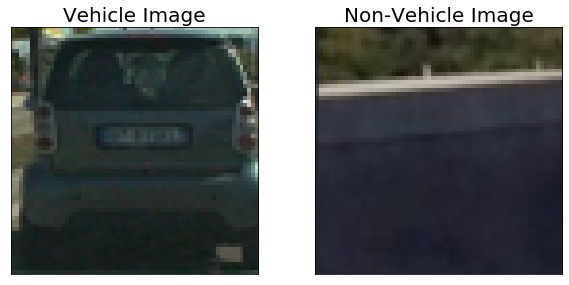

In [5]:
# Display output images
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(2, 2, 1)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
img_car = mpimg.imread(cars[np.random.randint(0,len(cars))])
plt.title('Vehicle Image', fontsize=20)
plt.imshow(img_car)

ax = fig.add_subplot(2, 2, 2)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
img_not_car = mpimg.imread(notcars[np.random.randint(0,len(notcars))])
plt.title('Non-Vehicle Image', fontsize=20)
plt.imshow(img_not_car)

## Histogram of Gradients (HOG)

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features

Visualize HOG on images

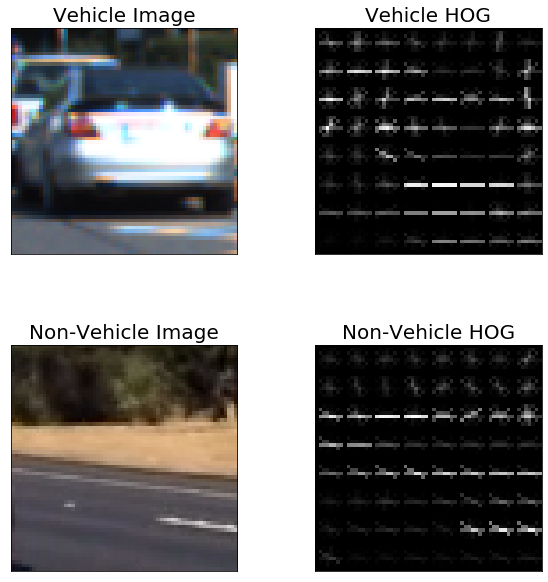

In [17]:
car_img = mpimg.imread(cars[np.random.randint(0,len(cars))])
_, car_dst = get_hog_features(car_img, 9, 8, 2, vis=True, feature_vec=True)
noncar_img = mpimg.imread(notcars[np.random.randint(0,len(notcars))])
_, noncar_dst = get_hog_features(noncar_img, 9, 8, 2, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Vehicle Image', fontsize=20)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Vehicle HOG', fontsize=20)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
ax3.imshow(noncar_img)
ax3.set_title('Non-Vehicle Image', fontsize=20)
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Vehicle HOG', fontsize=20)
ax4.xaxis.set_visible(False)
ax4.yaxis.set_visible(False)

## Color transform

In [18]:
def convert_color(image, color_space):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
    return feature_image

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    
    return hist_features

## Heatmap

In [19]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Exctract Features

In [120]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # Apply color conversion if other than 'RGB'
        feature_image = convert_color(image, color_space=color_space)     

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))        
        
    # Return list of feature vectors
    return features

# Feature extraction parameters
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:', color_space,'color space', orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block', hog_channel, 'hog channel',
     spatial_size, 'spatial size', hist_bins, 'hist bins')
print('Feature vector length:', len(X_train[0]))

116.14 Seconds to extract features
Using: HSV color space 9 orientations 8 pixels per cell and 2 cells per block ALL hog channel (32, 32) spatial size 32 hist bins
Feature vector length: 8460


## Train Classifier

In [121]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

4.68 Seconds to train SVC
Test Accuracy of SVC =  0.993
My SVC predicts:  [1. 0. 1. 1. 0. 0. 1. 0. 1. 1.]
For these 10 labels:  [1. 0. 1. 1. 0. 0. 1. 0. 1. 1.]
0.0 Seconds to predict 10 labels with SVC


## Find Car

In [122]:
def find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, show_all_rectangles=False):
    """
    Extracts features using hog sub-sampling and makes predictions
    """
    
    # I extracted training data from .png images 
    # (scaled 0 to 1 by mpimg) and the image I 
    # am searching is a .jpg (scaled 0 to 255)
    # Comment the following line if img is .png
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                    
    return box_list

## Search for Best Area

Becuase the size and position of cars in the image will be different depending on their distance from the camera, `find_cars` will have to be called a few times with different `ystart`, `ystop`, and `scale` values. These next few blocks of code are for determining the values for these parameters that work best.

Number of boxes:  308


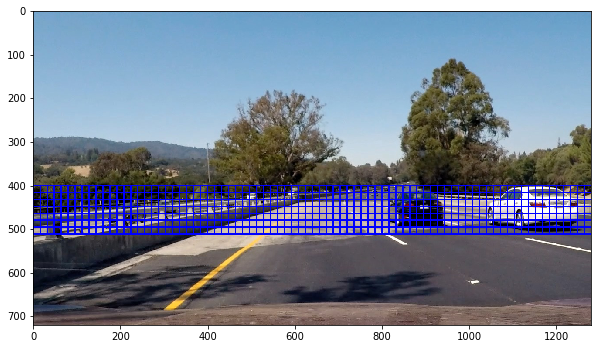

In [151]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

img = mpimg.imread('./test_images/test4.jpg')

bboxes = []

ystart = 400
ystop =  464
scale = 1.0
    
bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, show_all_rectangles=True))


ystart = 415
ystop = 515
scale = 1.0

bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, show_all_rectangles=True))


bounding_boxes = [item for sublist in bboxes for item in sublist] 
img = draw_boxes(img, bounding_boxes, color=(0, 0, 255), thick=2)
plt.figure(figsize=(10,10))
plt.imshow(img)
print('Number of boxes: ', len(bounding_boxes))

Number of boxes:  100


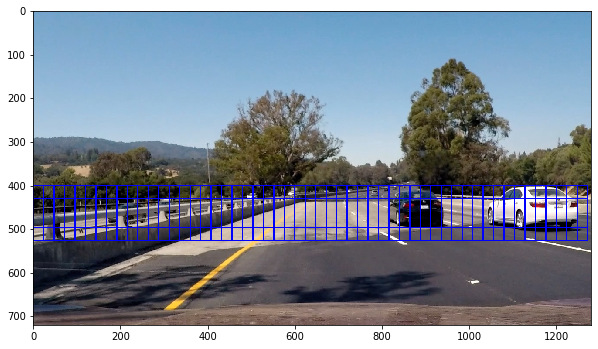

In [130]:
img = mpimg.imread('./test_images/test4.jpg')

bboxes = []

ystart = 400
ystop =  500
scale = 1.5
    
bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, show_all_rectangles=True))


ystart = 430
ystop = 530
scale = 1.5

bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, show_all_rectangles=True))


bounding_boxes = [item for sublist in bboxes for item in sublist] 
img = draw_boxes(img, bounding_boxes, color=(0, 0, 255), thick=2)
plt.figure(figsize=(10,10))
plt.imshow(img)
print('Number of boxes: ', len(bounding_boxes))

Number of boxes:  74


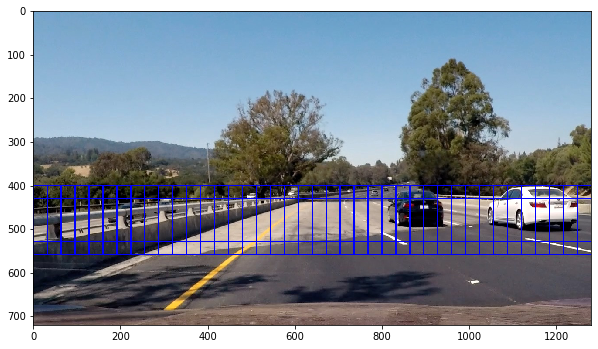

In [131]:
img = mpimg.imread('./test_images/test4.jpg')

bboxes = []

ystart = 400 # 400
ystop =  530 # 656
scale = 2.0
    
bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, show_all_rectangles=True))


ystart = 430
ystop = 560
scale = 2.0

bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, show_all_rectangles=True))


bounding_boxes = [item for sublist in bboxes for item in sublist] 
img = draw_boxes(img, bounding_boxes, color=(0, 0, 255), thick=2)
plt.figure(figsize=(10,10))
plt.imshow(img)
print('Number of boxes: ', len(bounding_boxes))

Number of boxes:  46


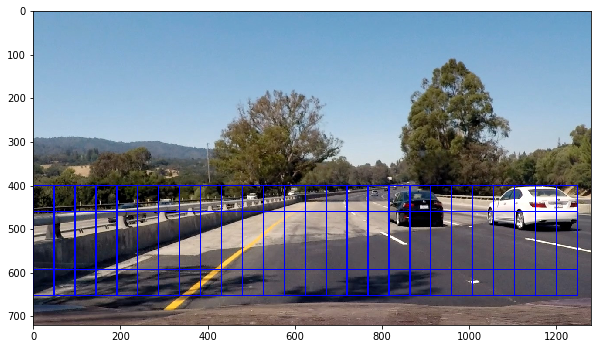

In [132]:
img = mpimg.imread('./test_images/test4.jpg')

bboxes = []

ystart = 400
ystop =  600
scale = 3.0
    
bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, show_all_rectangles=True))


ystart = 460
ystop = 660
scale = 3.0

bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, show_all_rectangles=True))


bounding_boxes = [item for sublist in bboxes for item in sublist] 
img = draw_boxes(img, bounding_boxes, color=(0, 0, 255), thick=2)
plt.figure(figsize=(10,10))
plt.imshow(img)
print('Number of boxes: ', len(bounding_boxes))

## Pipeline

In [143]:
def pipeline(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space):
    
    draw_img = np.copy(img)
    
    bboxes = []

    ystart = 400
    ystop =  464
    scale = 1.0

    bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space))


    ystart = 415
    ystop = 515
    scale = 1.0

    bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space))

    ystart = 400
    ystop =  500
    scale = 1.5

    bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space))


    ystart = 430
    ystop = 530
    scale = 1.5

    bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space))

    ystart = 400
    ystop =  530
    scale = 2.0

    bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space))


    ystart = 430
    ystop = 560
    scale = 2.0

    bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space))

    ystart = 400
    ystop =  600
    scale = 3.0

    bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space))


    ystart = 460
    ystop = 660
    scale = 3.0

    bboxes.append(find_car(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space))

    box_list = [item for sublist in bboxes for item in sublist]
    
    heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(draw_img), labels)
    
    return draw_img

## Test pipeline

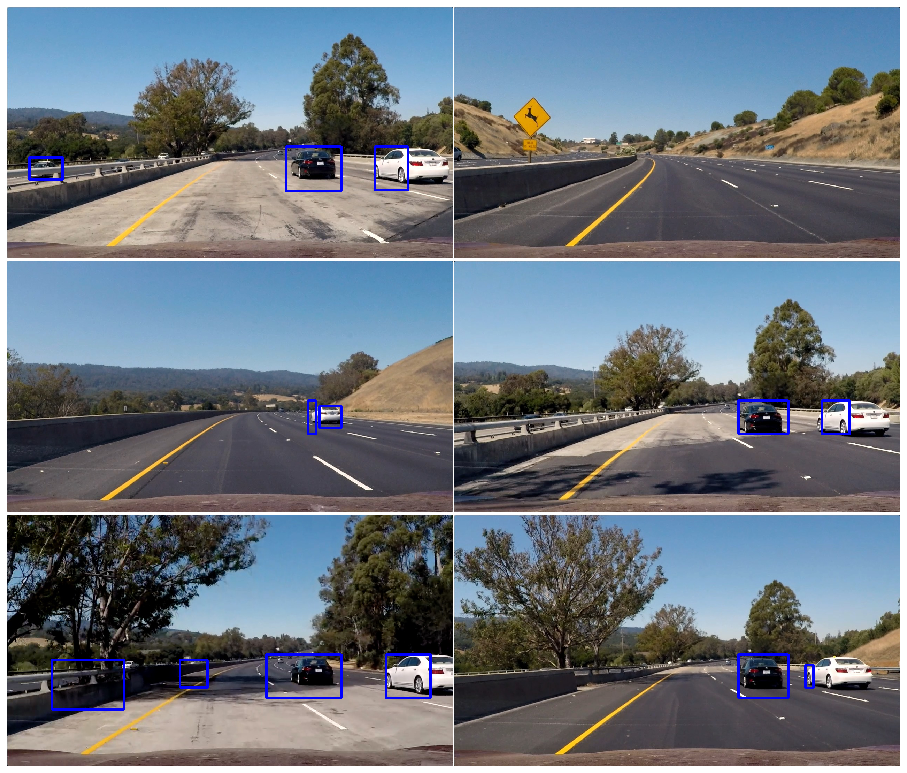

In [128]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, filename in enumerate(test_images):
    img = mpimg.imread(filename)
    axs[i].imshow(pipeline(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space))
    axs[i].axis('off')

## Test pipeline on video

In [96]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [97]:
output_video = './output_video.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(lambda image: pipeline(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space))
%time clip_test_out.write_videofile(output_video, audio=False)

t:   0%|                                                                              | 0/38 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./output_video.mp4.
Moviepy - Writing video ./output_video.mp4



Moviepy - Done !
Moviepy - video ready ./output_video.mp4
Wall time: 59.4 s


In [98]:
output_project_video = './output_project_video.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(lambda image: pipeline(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space))
%time clip_test_out.write_videofile(output_project_video, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./output_project_video.mp4.
Moviepy - Writing video ./output_project_video.mp4



Moviepy - Done !
Moviepy - video ready ./output_project_video.mp4
Wall time: 33min 36s
